In [50]:
from visualise_rhs import *
from visualize_foreground import *

import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import zoom

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [48]:
def get_n_snaps(path):
    n_prcos = read_mpi_info(path+"mpi_info.h5")
    snap_id = 0
    snaps = []

    if n_prcos > 1:
        exit_flag = False
        while True:
            for i in range(n_prcos):
                snap_filepath = path + f"snap{snap_id}_{i}.h5"
                if os.path.exists(snap_filepath):
                    snaps.append(snap_filepath)
                else:
                    exit_flag = True
                    break
            snap_id += 1
            if exit_flag:
                break
    else:
        while True:
            snap_filepath = path + f"snap{snap_id}.h5"
            if os.path.exists(snap_filepath):
                snaps.append(snap_filepath)
                snap_id += 1
            else:
                break

    return int(len(snaps)/n_prcos)

def resize_array(arr, target_size=300):
    if arr.shape[0] > target_size:
        # Calculate the zoom factor
        zoom_factor = target_size / arr.shape[0]
        # Apply zoom only on the first axis
        resized_arr = zoom(arr, zoom_factor)
        return resized_arr
    else:
        return arr

In [54]:
def plot_rhs(fig, ax, snap_nr, variable, info, title):   
    ax.set_xlabel("x [Solar radii]", fontsize=13)
    ax.set_ylabel("z [Solar radii]", fontsize=13)
    vmax = np.max(np.abs(variable))
    vmin = -vmax

    y0, y1, z0, z1 = info['y0'], info['y1'], info['z0'], info['z1']

    aspect = (y1-y0)/(z1-z0) * 1.2
    extent = np.array([y0,y1,z0,z1])/R_sun
    
    variable = resize_array(variable)
    im =ax.imshow(variable, origin="lower", extent=extent, aspect=aspect,vmin=vmin, vmax=vmax, cmap="RdBu")  
    ax.set_title(title, fontsize=13) 
    return im

def plot_fg(fig, ax, snap_nr, variable, info, title, vy, vz, quiver=False):
    ax.set_xlabel("x [Solar radii]", fontsize=13)
    ax.set_ylabel("z [Solar radii]", fontsize=13)
    vmax = np.max(np.abs(variable))
    vmin = -vmax

    y0, y1, z0, z1 = info['y0'], info['y1'], info['z0'], info['z1']
    nz_ghost = info['nz_ghost']
    dy, dz = info['dy'], info['dz']

    d = variable[nz_ghost:-1-nz_ghost+1,:]
    d = resize_array(d)

    aspect = (y1-y0)/(z1-z0) * 1.2
    extent = np.array([y0,y1,z0,z1])/R_sun

    im =ax.imshow(d, origin="lower", extent=extent, aspect=aspect,vmin=vmin, vmax=vmax, cmap="RdBu")
    ax.set_title(title, fontsize=13) 

    if quiver:
        vy = resize_array(vy[nz_ghost:-1-nz_ghost+1,:])
        vz = resize_array(vz[nz_ghost:-1-nz_ghost+1,:])

        z_shape, y_shape = vy.shape
        quiver_stride_y = int(y_shape//10)
        quiver_stride_z = int(z_shape//10)

        Y, X = np.mgrid[0:d.shape[0]:quiver_stride_z, 0:d.shape[1]:quiver_stride_y]
        # Convert pixel indices to data coordinates
        X_data = (X * dy)/R_sun
        Y_data = (Y * dz)/R_sun+z0/R_sun

        ax.quiver(X_data, Y_data, vy[::quiver_stride_z, ::quiver_stride_y], vz[::quiver_stride_z, ::quiver_stride_y])
        
    return im

def plot_all(fig, snap_nr, path, n_procs):
        cbar_labels = {"s1":"erg/K", "vy":"cm/s", "vz":"cm/s", "rhs_s1":"erg/K/s", "rhs_vy":"cm/s/s", "rhs_vz":"cm/s/s"}

        gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.6, hspace=0.3)

        # Order of keys for plotting
        plot_order = ["s1", "vy", "vz", "rhs_s1", "rhs_vy", "rhs_vz"]
        
        if n_procs > 1: 
            fg_variables, info = read_fg_mpi(snap_nr, n_procs, path)
            rhs_variables = read_rhs_mpi(snap_nr, n_procs, path+"rhs/")
        else:
            fg_variables, info = read_fg(path+"{}.h5".format(snap_nr))
            rhs_variables = read_rhs(snap_nr, path+"rhs/rhs_{}.h5".format(snap_nr))

        t = info['t'] * u.s
        t = t.to("day")
        for idx, key in enumerate(plot_order):
            i, j = divmod(idx, 3)  # Convert 1D index to 2D indices
            # Create the subplot using GridSpec indexing
            ax = fig.add_subplot(gs[i, 2*j])

            if key[:3] == 'rhs':
                title = r"$\partial_t$"+format_title(key[4:])
                im = plot_rhs(fig, ax, snap_nr, rhs_variables[key], info, title)
            else:
                vy = fg_variables['vy']; vz = fg_variables['vz']
                if key == 's1':
                    title = r"$s_1$"
                    quiver = True;
                elif key == 'vy':
                    title = r"$v_y$"
                    quiver = False
                elif key == 'vz':
                    title = r"$v_z$"
                    quiver = False
                im = plot_fg(fig, ax, snap_nr, fg_variables[key], info, title, vy, vz, quiver)
            
            # Create a new axes for the colorbar next to the current subplot
            pos = ax.get_position()
            cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
            cbar = plt.colorbar(im, cax=cax)

            # Set label for the colorbar
            cbar.set_label(cbar_labels[key], fontsize=13)

            # Enforce scientific notation
            #formatter = ScalarFormatter(useMathText=True)
            #formatter.set_scientific(True)
            #formatter.set_powerlimits((-1, 1))

        # Title for the entire plot with the time
        fig.suptitle(f"t={t.value:.1f} [{t.unit.to_string(format='latex_inline')}]", fontsize=15, y=0.96)

def animate_all(path, save_name, fps=4, save_interval=10):
    n_snaps = get_n_snaps(path)-1
    n_procs = read_mpi_info(path+"mpi_info.h5")

    fig = plt.figure(figsize=(16, 9))  # Create a figure
    def init_animation():
        plot_all(fig, 0, path, n_procs)

    def update_animation(snap_nr):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_all(fig, snap_nr, path, n_procs)  # Plot the new snapshot

    anim = FuncAnimation(fig, update_animation, interval=250, frames=range(0,n_snaps, save_interval), init_func=init_animation)
    anim.save(save_name, writer='ffmpeg', fps=fps, extra_args=['-vcodec', 'libx264'])

/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/matplotlib/quiver.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/uio/hume/student-u58/tabjone/.local/lib/python3.9/site-packages/matplotlib/quiver.py:645: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


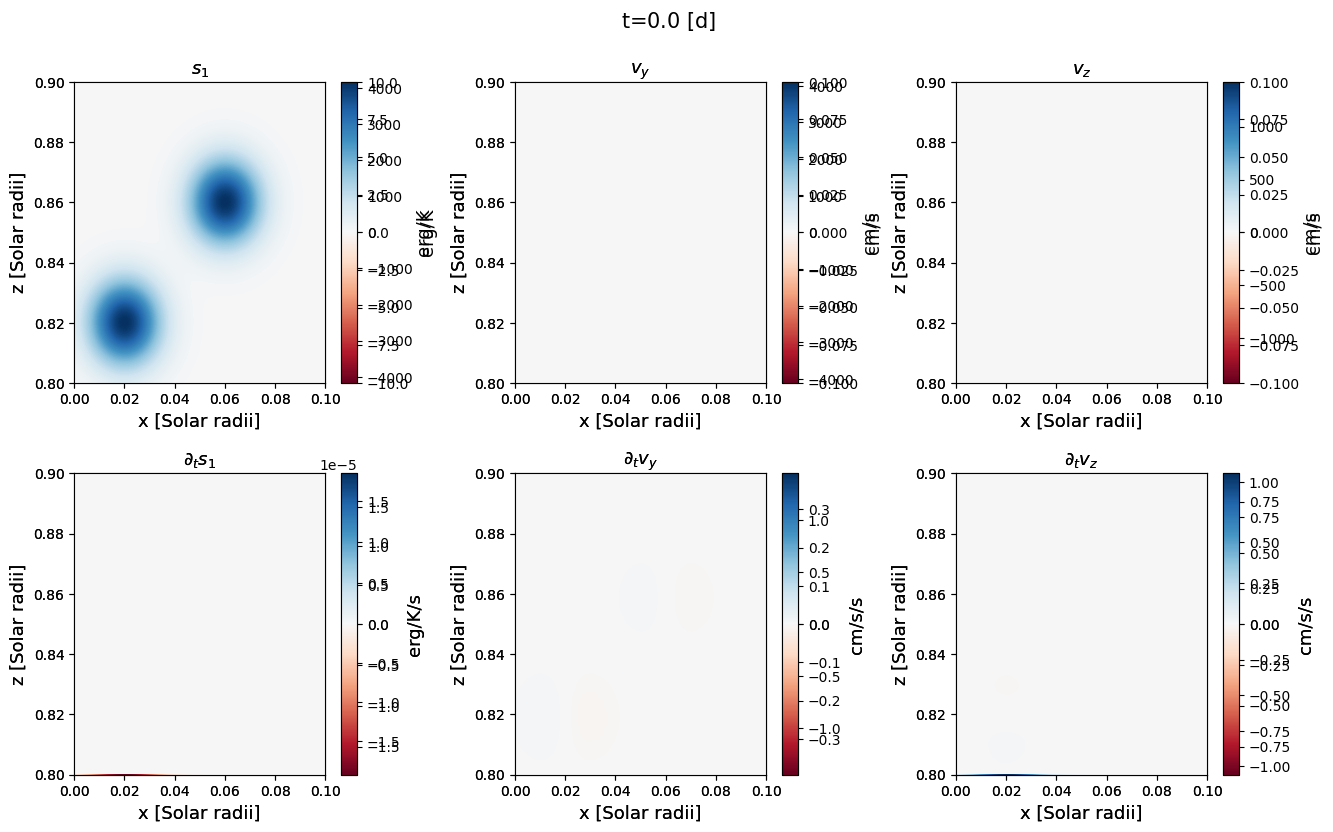

In [56]:
data_folder = "/mn/stornext/d10/data/tabjone/data/"
run_name = "4k_with_rhs_save/"

save_name = (data_folder+run_name).split('/')[-2]+'.mp4'

n_procs = read_mpi_info(data_folder+run_name+"mpi_info.h5")

animate_all(data_folder+run_name, save_name, fps=5, save_interval=1)

In [59]:
data_folder = "/mn/stornext/d10/data/tabjone/data/"
run_name = "bigger_soft_wall/"
rhs_location = data_folder + run_name + "rhs/"

n_procs = read_mpi_info(data_folder+run_name+"mpi_info.h5")

rhs_1 = read_rhs_mpi(30, n_procs, data_folder+run_name+"rhs/")
rhs_2 = read_rhs_mpi(30, n_procs, data_folder+"rhs_test/"+"rhs/")

Text(0.5, 1.0, 'Constant extrapolation')

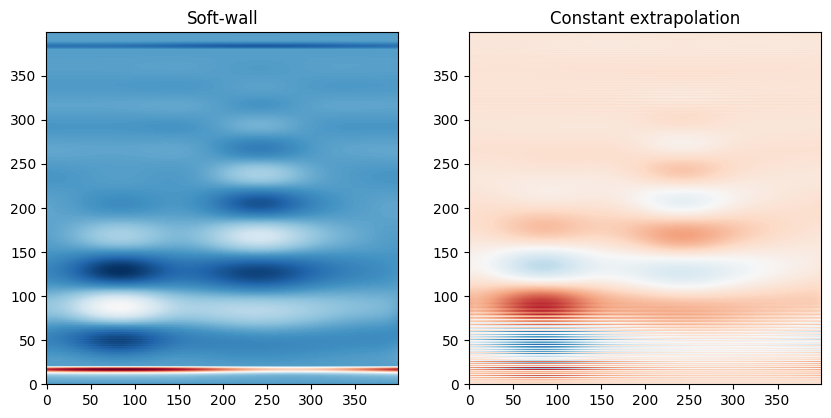

In [60]:
fig, ax= plt.subplots(ncols=2, figsize=(10,5))
ax[0].imshow(rhs_1['rhs_s1'], origin="lower", cmap="RdBu")
ax[1].imshow(rhs_2['rhs_s1'], origin="lower", cmap="RdBu")
ax[0].set_title("Soft-wall")
ax[1].set_title("Constant extrapolation")